# Tracing directors' career journeys using time series data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to another chapter of our exploration of how social networks influence the careers of movie directors. 

**What are we aiming to do?**

In `Phase_1_Tracking_Movie_Directors_Career.ipynb`, we identified over 63,000 directors who began their careers between 2003 and 2013. Our next step is to track how their careers unfold over time. To do this, we're constructing two types of datasets:
- Longitudinal Dataset (`directors_years_outcomes`): This tracks each director's career progression year by year from their debut to 2023. This dataset varies in length for each director, ranging from 11 to 21 rows for each year of their career, depending on when they entered the industry.
- Cross-sectional Dataset (`directors_cross_sectional`): This dataset summarizes the outcomes of each director's initial 11 years in the industry.

These datasets help us separate the influence of a director's own social capital from that of their collaborators:
- The longitudinal dataset allows us to see how changes in the social capital of collaborators over time might predict changes in directors' career outcomes.
- The cross-sectional dataset focuses on collaborators' social capital when the director first entered the industry and have minimal social capital themselves, thus highlighting the impact of their collaborators' social capital.

**How do we do this?**

1. Constructing time series data: Each row in this dataset represents one year in a director's career, from debut to 2023. We include variables such as:
- Annual directorial engagement: Indicates whether a director has directed a film in a given year, showing if they are still active.
- Dropout indicator: Shows if a director has not directed any films in the past 10 years, signaling a possible end to their directing activities.
- Survival analysis variables (`start_time` and `stop_time`): These measure how long directors remain active, focusing on their career phases.

2. Constructing cross-sectional data: This dataset compiles key aspects of each director's first 11 years post-debut. Variables include:
- Total movies directed: The total number of movies a director made post-debut.
- Career continuation indicator: Whether the director has continued making films during this period.
- Time to Second Movie: The elapsed time between a director’s first and second movie (if exists).

**Looking ahead**

By the end of this notebook, we will have compiled detailed datasets tracking each director's career trajectory, both annually and across their initial decade in the industry. These datasets will serve as the foundation for our upcoming analyses, where we will explore how factors like network connections and gender impact career paths in the film industry.

# 1. Constructing a time series dataset 

In this part of our analysis, we construct a dataset that captures the career trajectory of film directors on an annual basis. For this task, we use the `directors_full_filmography` dataset, which we created in a previous notebook (`Phase_1_Tracking_Movie_Directors_Career.ipynb`) and which lists all films directed by 63,169 directors in our study from their debut until 2023.

By the end, we should have a dataset, `directors_years`, where each row in the data represents a single year in the career of a director from their debut to 2023, even if they did not release any movies in some years. Columns include:
- `nconst_director`: A unique identifier for each director.
- `year`: The specific year being considered for that director's career.
- `debut_year`: The year when the director made their debut.

In [1]:
# Importing necessary libraries for data manipulation and handling
import pandas as pd  # data manipulation
import os  # interacting with the operating system, such as file paths
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from lifelines import KaplanMeierFitter

# Set the working directory to where the project files are located
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [2]:
# Load the filmography dataset for movie directors (2003-2023)
directors_full_filmography = pd.read_csv('directors_full_filmography.csv')

# Display the initial rows of the dataset to understand its structure
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0


In [3]:
# Convert the 'startYear' column to integer values 
directors_full_filmography['startYear'] = directors_full_filmography['startYear'].astype(int)

# Identify unique directors and define the range of years for our analysis (2003-2023)
# This range is chosen based on the debut years of directors being studied (2003-2013), extending to 2023 for a long-term look at their careers
directors = directors_full_filmography['nconst'].unique()
years = range(2003, 2024) 

# Generate all possible director-year combinations within the specified range
# This creates a framework to examine each director's career on a yearly basis
directors_years = pd.DataFrame([(director, year) for director in directors for year in years], columns=['nconst', 'year'])

# Merge the generated combinations with the original filmography data to include each director's debut year
# This allows us to filter combinations to only include years after each director's debut
directors_years = directors_years.merge(directors_full_filmography[['nconst', 'firstYear']].drop_duplicates(), on='nconst', how='left')

# Filter out rows that represent years before a director's debut, ensuring the dataset only contains relevant director-year pairs
directors_years = directors_years[directors_years['year'] >= directors_years['firstYear']].drop(columns=['firstYear'])
directors_years.rename(columns={'nconst': 'nconst_director'}, inplace=True)

# Identify the debut year for each director
debut_years = directors_years.groupby('nconst_director')['year'].min().reset_index()
debut_years.rename(columns={'year': 'debut_year'}, inplace=True)

# Merge the debut year back into the directors_years dataset to add a debut_year column
directors_years = pd.merge(directors_years, debut_years, on='nconst_director', how='left')

In [4]:
directors_years.head(25)

,nconst_director,year,debut_year
0,nm1131265,2004,2004
1,nm1131265,2005,2004
2,nm1131265,2006,2004
3,nm1131265,2007,2004
4,nm1131265,2008,2004
5,nm1131265,2009,2004
6,nm1131265,2010,2004
7,nm1131265,2011,2004
8,nm1131265,2012,2004
9,nm1131265,2013,2004


Everything is in order! Before moving on to adding variables indicating career longevity (our outcome variables), let's save `directors_years` as a separate file from the one with outcome variables `directors_years_outcomes`. With the `directors_years` data, we can streamline the process of adding new variables such as network, gender, and film genres without the need to repeatedly load the extensive outcome data. 

In [5]:
directors_years.to_csv("directors_years.csv", index=False)

# 2. Creating outcome variables for time series data

In this segment of the analysis, we'll create crucial outcome variables that will help us measure each director's career trajectory:

1. Active Engagement (`made_movie`): This binary indicator specifies whether a director released at least one movie in a given year. This provides a direct measure of a director's active engagement in directing during each year of their career. Notably, for a director's debut year, we set this indicator to zero, ensuring that our analysis focuses on activity after their debut.

2. Career Continuity (`dropout`): This variable indicates whether a director potentially dropped out of directing in a given year. We determine this by identifying the last year in which directors released a movie. Directors who have not released any movies since 2013 (the last decade of the observation period) are considered to have potentially dropped out. Conversely, for directors who were active after 2013, we do not specify a dropout year, implying continued involvement in the industry.

As we gear up for survival analysis, let's also create 

3. Relative Career Timing (`start_time` and `stop_time`): These variables are essential for survival analysis, as they allow us to measure the duration of directors' active phases. We calculate these timing variables relative to each director's debut year. This approach allows us to standardize the career timeline across our sample, focusing on the progression and duration of directors' careers without the variability introduced by different debut years.

By the end, we should have a dataset, `directors_years_outcomes` where each row represents a single year in the career of a director, with the following columns:
- `nconst_director`: A unique identifier for each director.
- `year`: The specific year being considered for that director's career.
- `debut_year`: The year when the director made their debut.
- `num_movies`: The number of movies released by the director in that particular year.
- `made_movie`: A binary indicator stating whether the director released any movies in that year (1 if yes, 0 if no).
- `dropoutYear`: A time-invariant variable indicating year the director potentially dropped out, assiged as missing value if the director is still active
- `dropout`: Indicates whether the director is considered to have potentially dropped out of the industry by that year.
- `start_time` and `stop_time`: The relative start and stop times from each director's debut year.

Let's start with creating a binary indicator (`made_movie`) to identify whether a director was active in a given year.

In [6]:
# taking a look at the director filmography data to figure out how to create outcome variables
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005,Drama,nm0000417,2005.0,5.3,950.0


In [7]:
# Aggregate the director's filmography data to count unique movies released by each director per year.
movies_released_per_year = directors_full_filmography.groupby(['nconst', 'startYear'])['tconst'].nunique().reset_index()

# Rename columns for clarity: director ID as 'nconst_director', release year as 'year', and number of movies as 'num_movies'.
movies_released_per_year.rename(columns={'nconst': 'nconst_director', 'startYear': 'year', 'tconst': 'num_movies'}, inplace=True)

# Merge the yearly movie release counts with the main dataset to include the number of movies each director released each year.
directors_years_outcomes = directors_years.merge(movies_released_per_year, on=['nconst_director', 'year'], how='left')

# Replace missing values in 'num_movies' with 0, indicating no movies were released by the director in those years.
directors_years_outcomes['num_movies'] = directors_years_outcomes['num_movies'].fillna(0)

# Create a binary indicator 'made_movie' to denote whether the director released any movies in a given year (1 if yes, 0 if no).
directors_years_outcomes['made_movie'] = (directors_years_outcomes['num_movies'] > 0).astype(int)

# For the director's debut year, set 'num_movies' and 'made_movie' to 0 so that the variables reflect activity after debut
directors_years_outcomes.loc[directors_years_outcomes['year'] == directors_years_outcomes['debut_year'], ['num_movies', 'made_movie']] = 0

In [8]:
directors_years_outcomes.head(25)

,nconst_director,year,debut_year,num_movies,made_movie
0,nm1131265,2004,2004,0.0,0
1,nm1131265,2005,2004,0.0,0
2,nm1131265,2006,2004,0.0,0
3,nm1131265,2007,2004,0.0,0
4,nm1131265,2008,2004,0.0,0
5,nm1131265,2009,2004,0.0,0
6,nm1131265,2010,2004,0.0,0
7,nm1131265,2011,2004,0.0,0
8,nm1131265,2012,2004,0.0,0
9,nm1131265,2013,2004,1.0,1


Looks great! Next, we'll move on to identifying career dropout (`dropout`).

In [9]:
# Group by director ID and identify the latest year of movie release to determine the last active year for each director.
last_movie_year = directors_full_filmography.groupby('nconst')['startYear'].max().reset_index()

# Identify directors who haven't made any movies in the last 10 years (between 2014 and 2023)
# These people are considered to have potentially dropped out
dropout_directors = last_movie_year[last_movie_year['startYear'] < 2014].copy()

# Set 'dropoutYear' as the year following their last movie release, marking when they might have left the industry.
dropout_directors['dropoutYear'] = dropout_directors['startYear'] + 1

# Directors who made a movie in 2014 or later are considered still active
# set 'dropoutYear' as NA, indicating they haven't dropped out within the study period
active_directors = last_movie_year[last_movie_year['startYear'] >= 2014].copy()
active_directors['dropoutYear'] = pd.NA

# Combine the dataframes to get a complete view of all directors' potential dropout years.
all_directors_dropout = pd.concat([dropout_directors, active_directors], ignore_index=True).sort_values(by='nconst')

In [10]:
# Display the first few rows of the combined dataframe
all_directors_dropout.head()

,nconst,startYear,dropoutYear
43523,nm0000083,2022,<NA>
0,nm0000136,2009,2010
1,nm0000147,2010,2011
43524,nm0000154,2016,<NA>
2,nm0000155,2013,2014


In [11]:
# Merge the 'dropoutYear' information into the main dataset to indicate the potential dropout year for each director.
directors_years_outcomes = pd.merge(directors_years_outcomes, all_directors_dropout[['nconst', 'dropoutYear']],
                                    how='left', left_on='nconst_director', right_on='nconst')

# Remove the redundant 'nconst' column after merging.
directors_years_outcomes.drop(columns='nconst', inplace=True)

# Initialize a 'dropout' column with 0, indicating no dropout event by default.
directors_years_outcomes['dropout'] = 0

# Update 'dropout' to 1 for years equal to or beyond the 'dropoutYear', marking it as the potential dropout event.
directors_years_outcomes['dropoutYear'] = pd.to_numeric(directors_years_outcomes['dropoutYear'], errors='coerce')  # Coerce errors will convert non-numeric to NaN
directors_years_outcomes['dropout'] = ((directors_years_outcomes['year'] >= directors_years_outcomes['dropoutYear'].fillna(9999)).astype(int))

In [12]:
# Display the first few rows
directors_years_outcomes.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout
0,nm1131265,2004,2004,0.0,0,NaN,0
1,nm1131265,2005,2004,0.0,0,NaN,0
2,nm1131265,2006,2004,0.0,0,NaN,0
3,nm1131265,2007,2004,0.0,0,NaN,0
4,nm1131265,2008,2004,0.0,0,NaN,0
5,nm1131265,2009,2004,0.0,0,NaN,0
6,nm1131265,2010,2004,0.0,0,NaN,0
7,nm1131265,2011,2004,0.0,0,NaN,0
8,nm1131265,2012,2004,0.0,0,NaN,0
9,nm1131265,2013,2004,1.0,1,NaN,0


Fianlly, we create `start_time` and `stop_time` variables for each director.

In [13]:
# Calculate relative start and stop times based on the director's debut year
directors_years_outcomes['start_time'] = directors_years_outcomes['year'] - directors_years_outcomes['debut_year']
directors_years_outcomes['stop_time'] = directors_years_outcomes['start_time'] + 1

In [14]:
directors_years_outcomes.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5
5,nm1131265,2009,2004,0.0,0,NaN,0,5,6
6,nm1131265,2010,2004,0.0,0,NaN,0,6,7
7,nm1131265,2011,2004,0.0,0,NaN,0,7,8
8,nm1131265,2012,2004,0.0,0,NaN,0,8,9
9,nm1131265,2013,2004,1.0,1,NaN,0,9,10


In [15]:
directors_years_outcomes.to_csv("directors_years_outcomes.csv", index=False)

# 3. Exploring career longevity through visualization

**Kaplan-Meier survival analysis**

To deepen our understanding of directors' career longevity, we employ the Kaplan-Meier survival analysis. This method helps us to visualize the duration directors typically remain active in the film industry. By examining these survival curves, we can pinpoint critical periods when directors are most at risk of exiting the industry, which is essential for developing strategies to support career sustainability.

In [28]:
# Load the longitudinal dataset tracking each director's career progression
directors_data = directors_years_outcomes

# Fill missing values in 'dropoutYear' with 2023, assuming active directors are observed until the end of the study
directors_data['dropoutYear'] = directors_data['dropoutYear'].fillna(2023)

# Filter the dataset to include only the career years up to the director's dropout year or the last year of observation
filtered_data = directors_data[directors_data['year'] <= directors_data['dropoutYear']]

# Aggregate data to determine the last year each director was observed and their status at that time
last_observation = filtered_data.groupby('nconst_director').agg(
    last_year=('start_time', 'max'), # The maximum 'start_time' gives the last year of data for each director
    last_status=('dropout', 'last') # 'last' captures whether the director had dropped out by their last year of observation
)

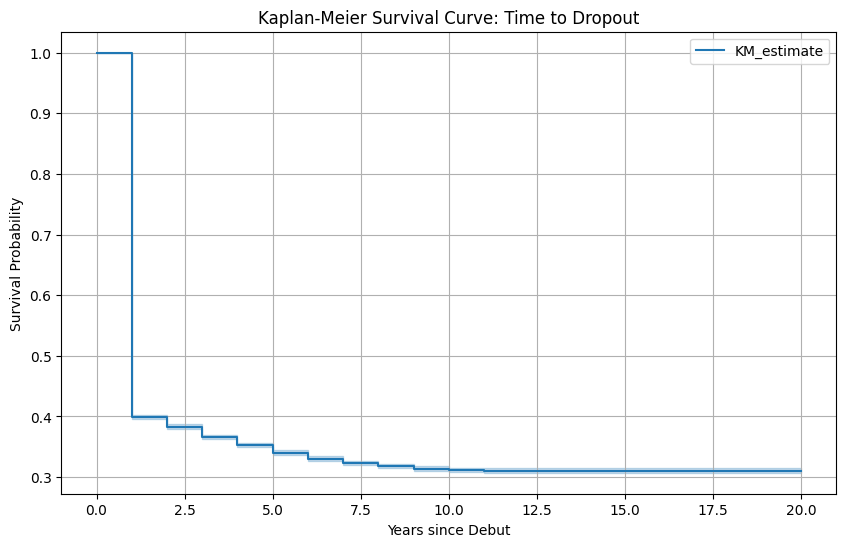

In [33]:
# Initialize the Kaplan-Meier Fitter from the lifelines library, a tool for survival analysis
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier model using the duration each director was observed and their dropout status
kmf.fit(durations=last_observation['last_year'], event_observed=last_observation['last_status'])

# Plot the Kaplan-Meier survival function to visualize the probability of directors staying active over time
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve: Time to Dropout')
plt.xlabel('Years since Debut')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

The survival curve starts with a probability of 100%, indicating that all directors are active at the beginning of their careers. The x-axis represents the years since their debut, spanning up to 20 years in our analysis.

The curve shows a sharp drop in survival probability within the first year, plummeting from 100% to around 40%. This indicates that about 60% of directors do not make a second movie, likely due to challenges such as securing new projects, financial constraints, or the competitive nature of the film industry.

After the initial steep decline, the survival curve descends more gradually. This suggests that while the risk of dropping out continues, it diminishes after the first two years. By the 10-year mark, the survival probability levels off around 30%, indicating that directors who navigate the early challenges of their careers tend to achieve more stable trajectories.

**Cohort Analysis**

Next, we examine whether directors entering the industry at different times experience similar career trajectories.

In [37]:
# Calculate the last year observed and the last status for each director, grouped by director ID and debut year
last_observation_by_debut = filtered_data.groupby(['nconst_director', 'debut_year']).agg(
    last_year=('start_time', 'max'),  # The maximum 'start_time' gives the last year of data for each director
    last_status=('dropout', 'last')  # 'last' captures whether the director had dropped out by their last year of observation
).reset_index()

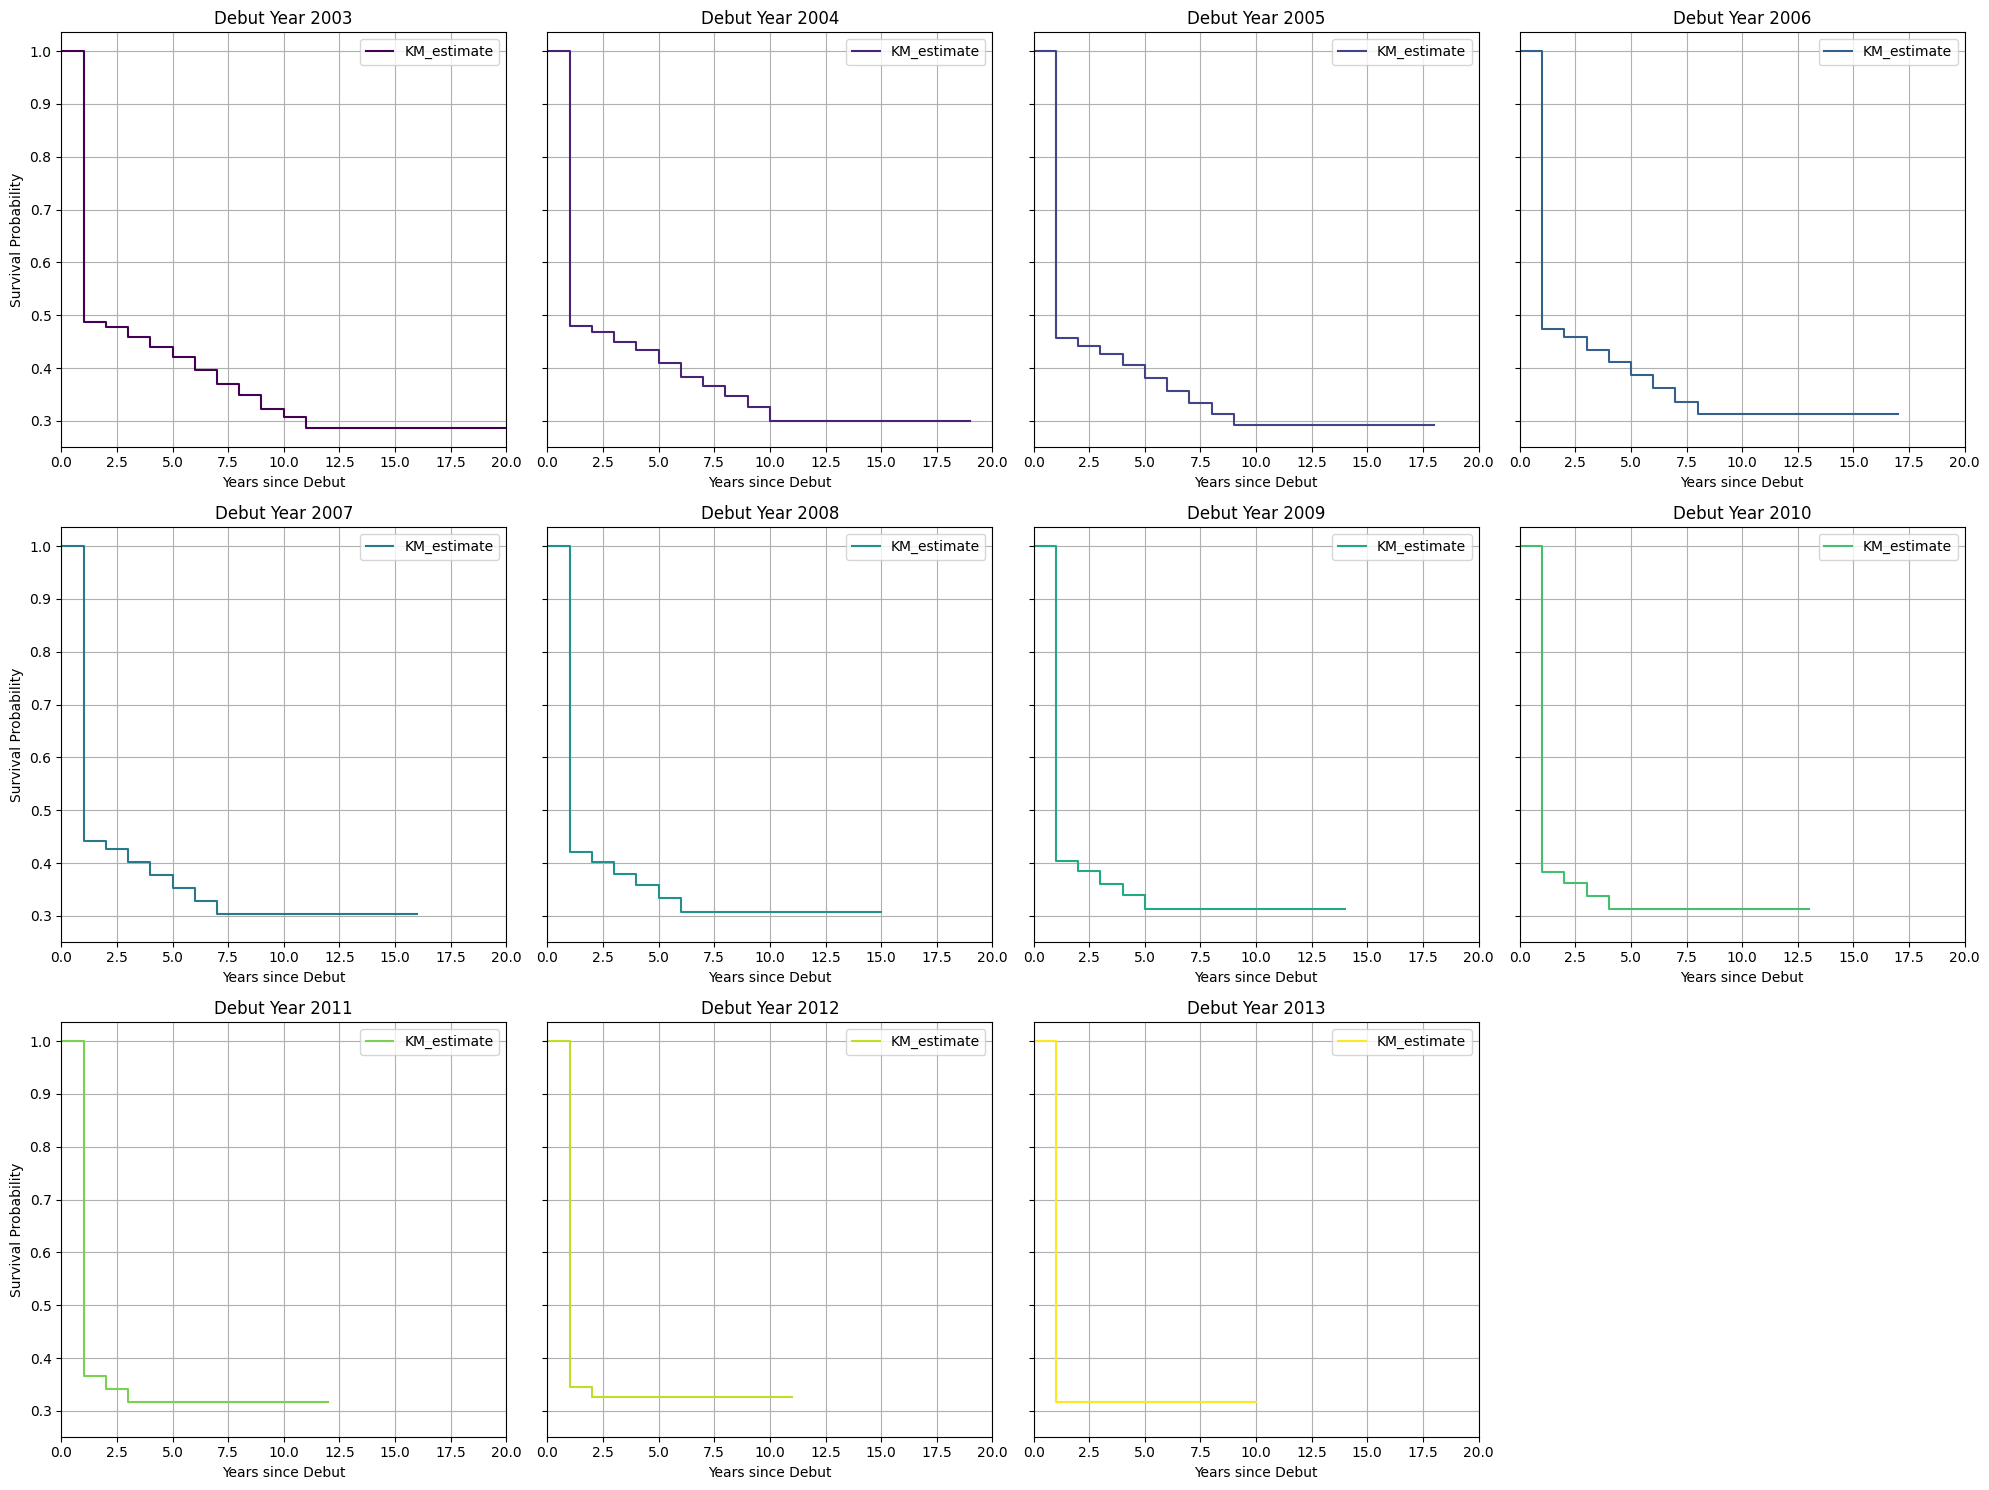

In [42]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Get unique debut years and sort them
debut_years = sorted(last_observation_by_debut['debut_year'].unique())

# Define the number of plots per row
plots_per_row = 4

# Calculate number of rows needed (each row has 4 plots)
n_rows = (len(debut_years) + plots_per_row - 1) // plots_per_row

# Create subplots
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(20, 5 * n_rows), sharey=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(debut_years)))

# Determine the maximum duration to set a consistent x-axis range
max_duration = last_observation_by_debut['last_year'].max()

# Loop through each debut year to plot its Kaplan-Meier curve
for i, year in enumerate(debut_years):
    ax = axes[i]
    # Subset data for the cohort
    cohort_data = last_observation_by_debut[last_observation_by_debut['debut_year'] == year]
    
    # Fit the Kaplan-Meier model
    kmf.fit(durations=cohort_data['last_year'], event_observed=cohort_data['last_status'])
    
    # Plot the survival function on the designated subplot
    kmf.plot_survival_function(ax=ax, color=colors[i], ci_show=False)
    ax.set_title(f'Debut Year {year}')
    ax.set_xlabel('Years since Debut')
    ax.set_ylabel('Survival Probability')
    ax.set_xlim(0, max_duration)  # Set the same x-axis limits for all subplots
    ax.grid(True)

# Hide unused subplots if not divisible by 4
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout for better fit
plt.tight_layout()
plt.show()


Dropout rates peak during the second year for all cohorts, with a general decline afterward. Directors who persist past these initial years often enjoy longer and more stable careers.

For newer cohorts, such as directors debuting in 2013, our data spans few years into their career. This limitation might skew observed dropout rates toward the end of our observation period. That is, directors active between 2014 and 2023 are considered still active. This means that the zero dropout rates in later years likely reflect our study's timeframe rather than indicating the end of these directors' careers. This also means that direct comparisons between cohorts can be misleading-cohorts with longer observation periods might show lower dropout rates simply because they've had more time to direct films, potentially skewing comparative analyses.

On the other hand, all directors in our study have at least 10 years of observation following their debut year. It's hard to imagine that individuals who haven't directed a film in over a decade would return to the industry. Just for fun, let's count how many people actually do that. 

In [ ]:
# Load the longitudinal dataset tracking each director's career progression
directors_data = directors_years_outcomes

# Filter data to include only the years after each director's debut
directors_data = directors_data[directors_data['year'] > directors_data['debut_year']]

# Add a new column 'no_movie' to indicate if no movie was released in a given year. 
# This column is a boolean where True (1) indicates no movies were released, and False (0) if at least one movie was released.
directors_data['no_movie'] = directors_data['made_movie'] == 0

# Create a 'group' column that assigns a unique group number for consecutive years without a movie for each director. 
# This group number increases every time a movie is released, effectively segmenting the director's career into periods of activity and inactivity.
directors_data['group'] = directors_data.groupby('nconst_director')['no_movie'].transform(lambda x: (~x).cumsum())

# Calculate the number of consecutive years without movie releases within each activity segment (group) for each director. 
# This is done by cumulatively summing the 'no_movie' column within each group, resetting the count at the start of a new group.
directors_data['no_movie_years'] = directors_data.groupby(['nconst_director', 'group'])['no_movie'].cumsum()

In [150]:
# Define a function to determine if a director resumed making movies after at least a 10-year gap of no movie releases.
def check_post_gap_activity(group):
    # Check if the maximum number of consecutive no-movie years in any segment for a director is 10 or more.
    if group['no_movie_years'].max() >= 10:
        # If so, find the year when the 10-year gap first completes
        year_gap_ends = group[group['no_movie_years'] == 10]['year'].min()
        # After identifying the end of the 10-year gap, check if there's any subsequent year where a movie was made.
        return group[group['year'] > year_gap_ends]['made_movie'].any()
    # Return False if there was no 10-year gap or if no movies were made after the gap.
    return False

# Apply the defined function to each director's grouped data to check if they resumed making movies after a 10-year gap. 
# This is done across all directors in the dataset.
# The function returns True if the director resumed making movies after the gap and False otherwise.
resumed_directors = directors_data.groupby('nconst_director').apply(check_post_gap_activity)

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_3088/2412207757.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumed_directors = directors_data.groupby('nconst_director').apply(check_post_gap_activity)


In [151]:
# Calculate the number of directors who resumed making movies after a 10-year gap
resumed_directors.sum()

2447

In [152]:
# Calculate the number of directors who experienced a 10-year gap
len(directors_data[directors_data['no_movie_years'] >= 10]['nconst_director'].unique())

45970

Among the 45,970 directors who experienced a hiatus of 10 years or more, 2,447 (5%) returned to the industry. This is higher than I expected but still highlights the rarity of such comebacks.

# 4. Creating cross-sectional dataset

In this segmant, we create a cross-sectional dataset capturing detailed career information within the first 11 years of each director's career, starting from their debut. This dataset will allow us to control for different debut year since everyone has the same observation timeline. 

With this dataset, we'll investigate the time it takes for a director to release their second movie. It will include the following columns:
- `nconst_director`: A unique identifier for each director. 
- `debut_year`: The year in which a director released their first movie. 
- `time_to_second_movie`: The number of years from the director's debut to the release of their second movie. This is the primary variable of interest for survival analysis, indicating how quickly directors follow up their debut with another film. If a director has not released a second movie within the first 11 years, this is filled with an upper limit value (e.g., 11), representing censored data in survival analysis.
- `event`: A binary indicator coded as 1 if the second movie was made (non-censored), and 0 if the second movie was not made by the end of the study period (censored). This variable is essential for survival analysis, as it helps differentiate between directors who have reached the event of interest (second movie release) and those who have not within the study frame.
- `total_movies`: The total number of movies a director released within the first 11 years of their career.

In [164]:
directors_years_outcomes.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5
5,nm1131265,2009,2004,0.0,0,NaN,0,5,6
6,nm1131265,2010,2004,0.0,0,NaN,0,6,7
7,nm1131265,2011,2004,0.0,0,NaN,0,7,8
8,nm1131265,2012,2004,0.0,0,NaN,0,8,9
9,nm1131265,2013,2004,1.0,1,NaN,0,9,10


In [154]:
# Filter the data to include only the first 11 years of each director's career
filtered_data = directors_years_outcomes[directors_years_outcomes['start_time'] <= 10].copy()

# Calculate cumulative movies for each director over time
filtered_data['cumulative_movies'] = filtered_data.groupby('nconst_director')['num_movies'].cumsum()

# Determine the minimum year when cumulative movies reach or exceed 1 
# (meaning their second movie since we set 0 for number of movies in their debut year to focus on analyzing career after debut)
second_movie_time = filtered_data[filtered_data['cumulative_movies'] >= 1].groupby('nconst_director')['start_time'].min()

# Create a DataFrame from the second_movie_time series
second_movie_df = second_movie_time.reset_index()
second_movie_df.columns = ['nconst_director', 'time_to_second_movie']

# Retrieve all director IDs and their debut year
# Merge this with the second_movie_df to include all directors
# Directors without a second movie will have NaN in 'time_to_second_movie'
directors_cross_sectional = filtered_data[['nconst_director', 'debut_year']].drop_duplicates().merge(second_movie_df, on='nconst_director', how='left')

# Create event indicator
directors_cross_sectional['event'] = (~directors_cross_sectional['time_to_second_movie'].isna()).astype(int)  # 1 if second movie made, 0 if not

# Handling the time variable, using the maximum study period for those who didn't make a second movie:
directors_cross_sectional['time_to_second_movie'] = directors_cross_sectional['time_to_second_movie'].fillna(11)

In [157]:
# Calculate the total number of movies each director made within the first 11 years
total_movies = directors_years_outcomes[directors_years_outcomes['start_time'] < 11].groupby('nconst_director')['num_movies'].sum().reset_index()
total_movies.columns = ['nconst_director', 'total_movies']

# Merge this back to the main DataFrame to include all directors
directors_cross_sectional = directors_cross_sectional.merge(total_movies, on='nconst_director', how='left')

In [163]:
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.0,1,1.0
1,nm1130611,2004,11.0,0,0.0
2,nm0290651,2003,11.0,0,0.0
3,nm0404033,2003,5.0,1,1.0
4,nm0000417,2005,2.0,1,1.0


In [ ]:
directors_cross_sectional.to_csv("directors_cross_sectional.csv", index=False)

# 5. Exploring directors' first career decade through visualization

Now, we visualize this cross-sectional data to better understand directors' career trajectories and productivity 10 years following their debut. 

**Proportion of Directors Releasing a Second Movie**

We begin by examining how many directors released a second movie within the first 11 years of their career versus those who did not. This visualization helps us gauge the overall continuity and resilience of directors in the industry.

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_2047/164616166.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')


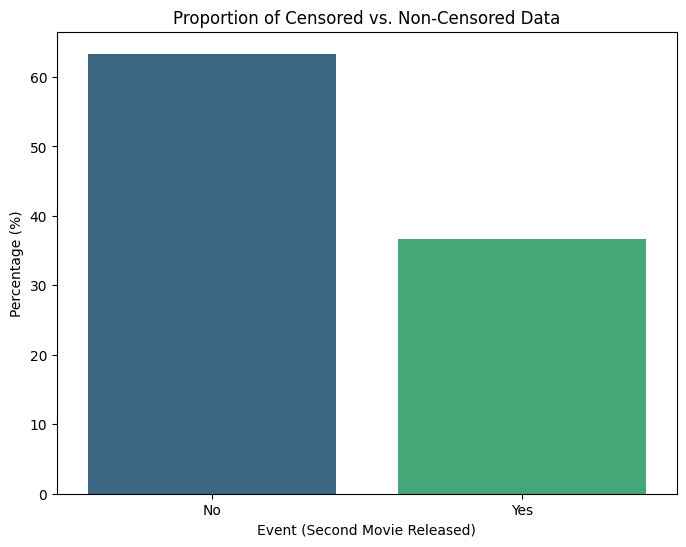

In [39]:
# Calculate the counts of censored vs. non-censored data
event_counts = directors_cross_sectional['event'].value_counts(normalize=True) * 100  # Get percentages

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=event_counts.index, y=event_counts.values, palette='viridis')
plt.title('Proportion of Censored vs. Non-Censored Data')
plt.xlabel('Event (Second Movie Released)')
plt.ylabel('Percentage (%)')
plt.xticks([0, 1], ['No', 'Yes'])  # Relabel the x-ticks for clarity

plt.show()

So, 65% of directors did not make another movie 10 years after their debut. This significant percentage underscores the challenges and barriers that directors face in sustaining their careers.

**Kaplan-Meier Survival Function: Time to Second Movie**

Next, we use the Kaplan-Meier survival analysis to model the probability of directors not releasing a second movie over time. This survival curve helps identify the critical periods when directors are most likely to drop out from making movies.

Y-axis represents the probability that a director has not released their second movie by a given time. 
X-axis represents the time in years since a director's debut.

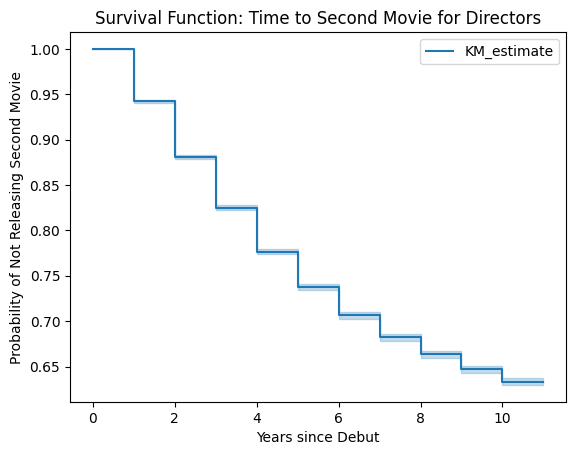

In [3]:
# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=directors_cross_sectional['time_to_second_movie'], event_observed=directors_cross_sectional['event'])

# Plot the survival function
kmf.plot_survival_function()
plt.title('Survival Function: Time to Second Movie for Directors')
plt.xlabel('Years since Debut')
plt.ylabel('Probability of Not Releasing Second Movie')
plt.show()

The probability of not releasing a second movie decreases rapidly in the first 5 years, indicating that many directors release their second movie early in their careers. After 5 years, the decline continues but at a slower rate, suggesting a steady but slower pace of second movie releases. By 10 years, about 35% of directors have released their second movie, while 65% have not.

**Distribution of Time to Second Movie Among Directors Who Made a Second Movie**

Next, we zoom in on the directors who did release a second movie, visualizing the distribution of the time it took them to do so with a histogram. This histogram, with overlaid mean and median lines, provides insights into typical timelines and identifies outliers.

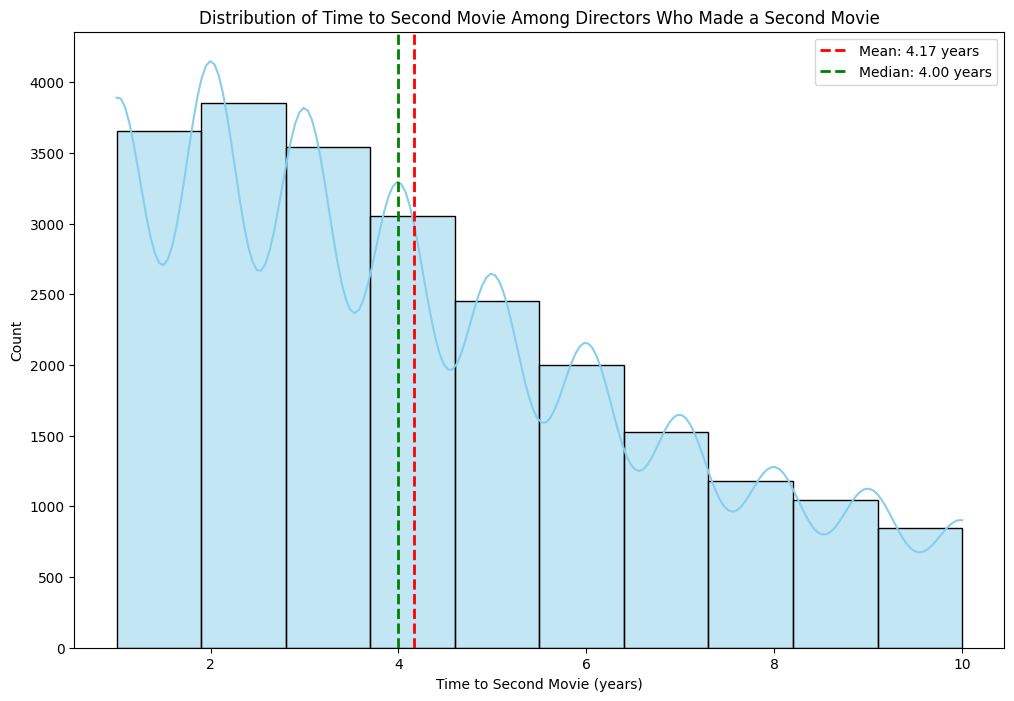

In [18]:
# Filter data to include only directors who released a second movie
released_data = directors_cross_sectional[directors_cross_sectional['event'] == 1]

# Calculate mean and median time to second movie
mean_time = released_data['time_to_second_movie'].mean()
median_time = released_data['time_to_second_movie'].median()

# Create the histogram
plt.figure(figsize=(12, 8))
sns.histplot(released_data['time_to_second_movie'], bins=10, kde=True, color='skyblue', alpha=0.5)
plt.axvline(mean_time, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_time:.2f} years')
plt.axvline(median_time, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_time:.2f} years')

# Adding labels and title
plt.title('Distribution of Time to Second Movie Among Directors Who Made a Second Movie')
plt.xlabel('Time to Second Movie (years)')
plt.ylabel('Count')
plt.legend()

plt.show()

A significant proportion of directors release their second movie within the first 3 years. After that, the number of directors releasing their second movie decreases gradually.

The closeness of the mean and median suggests that the distribution is fairly symmetric, with a slightly longer tail for directors taking more time.

**Distribution of Number of Movies Made by Directors After Debut**

Now, we create a histogram to show the distribution of the total number of movies made by directors within the 10 years following their debut, including mean and median lines. This helps us understand overall productivity of directors.

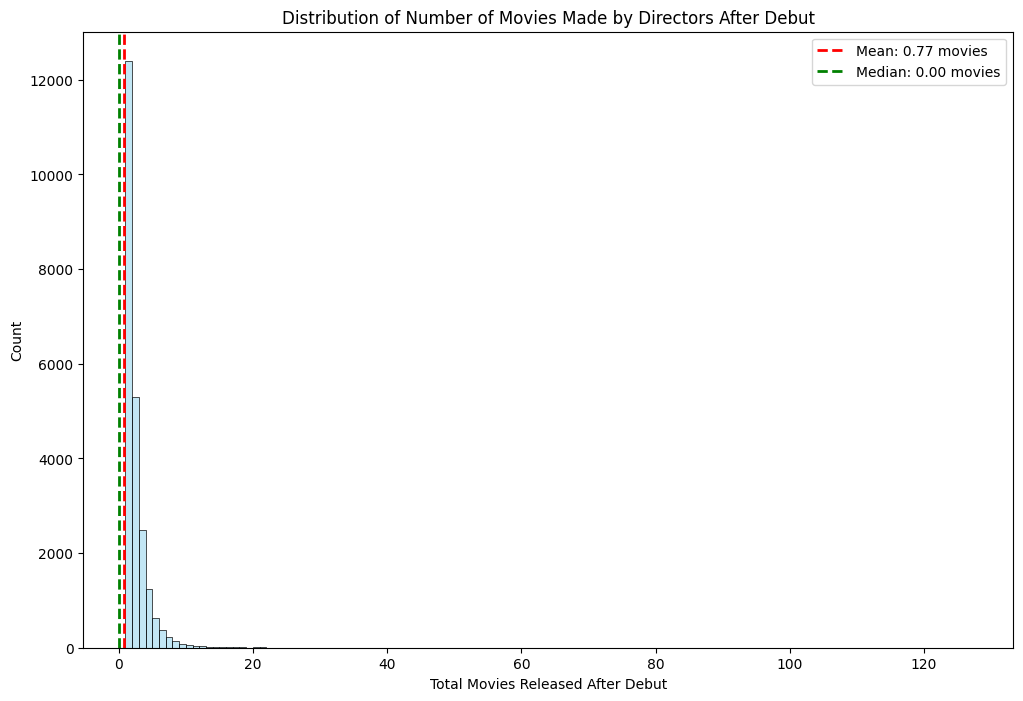

In [28]:
# Calculate mean and median total movies
mean_total_movies = directors_cross_sectional['total_movies'].mean()
median_total_movies = directors_cross_sectional['total_movies'].median()

# Create a histogram for the distribution of the number of movies made by directors in the first 11 years
plt.figure(figsize=(12, 8))
sns.histplot(directors_cross_sectional['total_movies'], bins=range(1, int(directors_cross_sectional['total_movies'].max()) + 2), color='skyblue', alpha=0.5)

# Add mean and median lines
plt.axvline(mean_total_movies, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_total_movies:.2f} movies')
plt.axvline(median_total_movies, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_total_movies:.2f} movies')

# Adding labels and title
plt.title('Distribution of Number of Movies Made by Directors After Debut')
plt.xlabel('Total Movies Released After Debut')
plt.ylabel('Count')
plt.legend()

plt.show()

The right-skewed nature of the distribution suggests that most directors produce few or no additional movies, while a few are highly productive. The median being 0.00 movies suggests that more than half of the directors did not release any additional movies beyond their debut within the 11-year period. However, there are a few directors who have made an exceptionally high number of movies (up to around 120 movies). 

**Percentage of Directors by Total Movies Released within the First 11 Years**

Finally, we categorize directors based on the number of movies they made in their first 11 years, calculate the percentage for each category, and visualize this data in a bar chart. This helps us understand the distribution of directors' productivity.

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_2047/1621990030.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_percentages.index, y=movie_percentages.values, palette='viridis')


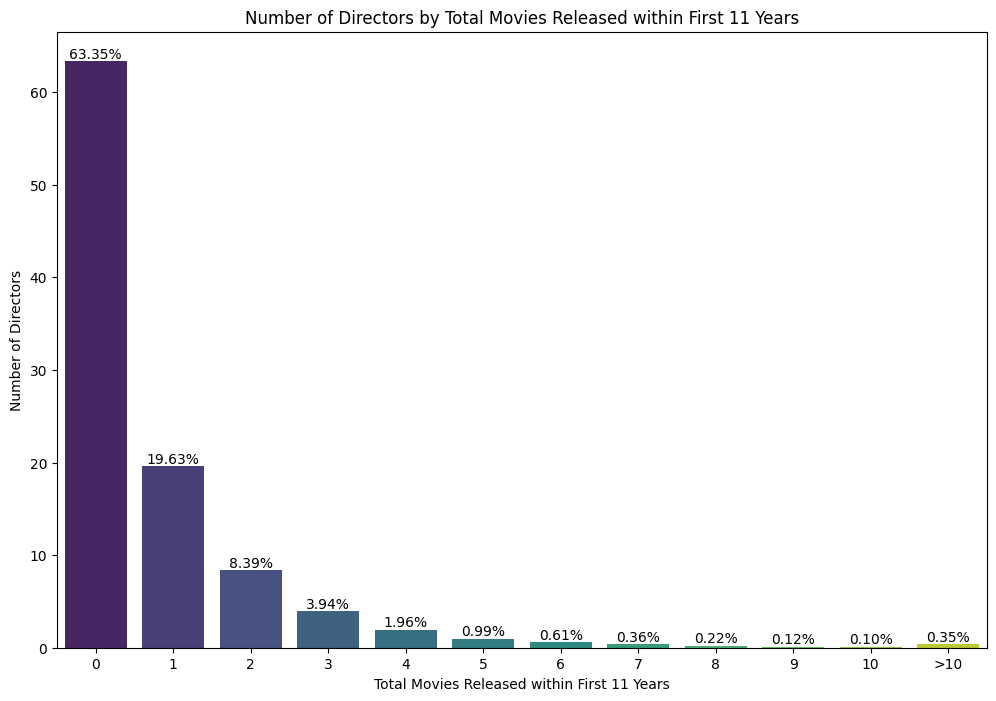

In [37]:
# Create a new column to categorize the number of movies
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float('inf')]
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '>10']
directors_cross_sectional['movie_category'] = pd.cut(directors_cross_sectional['total_movies'], bins=bins, labels=labels[:-1], right=False, include_lowest=True)
directors_cross_sectional['movie_category'] = directors_cross_sectional['movie_category'].cat.add_categories('>10')
directors_cross_sectional.loc[directors_cross_sectional['total_movies'] > 10, 'movie_category'] = '>10'

# Count the number of directors in each category
movie_counts = directors_cross_sectional['movie_category'].value_counts().sort_index()

# Calculate the percentage of directors in each category
total_directors = directors_cross_sectional.shape[0]
movie_percentages = (movie_counts / total_directors) * 100

# Create the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=movie_percentages.index, y=movie_percentages.values, palette='viridis')

# Adding labels and title
plt.title('Number of Directors by Total Movies Released within First 11 Years')
plt.xlabel('Total Movies Released within First 11 Years')
plt.ylabel('Number of Directors')

# Display the count above each bar
for index, value in enumerate(movie_percentages.values):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

plt.show()

The fact that 63.35% of directors do not release any additional movies after their debut suggests significant barriers to sustained movie directing.

About 30 percent of directors release a small number of movies (1-3). This indicates a moderate level of productivity where directors might be facing intermittent success or working on fewer projects that take longer to complete. Very few directors release more than 5 movies within the first 11 years, with the percentage dropping significantly as the number of movies increases.

We now have the data to trace their career trajectories. In upcoming analyses, we will explore the predictors of these success metrics, aiming to identify factors that contribute to sustained productivity and career longevity.